# Predicting Heart Disease with Age, Serum Cholesterol, Resting Blood Pressure and Maximum Heart Rate


## Introduction
Heart disease is a disease that refers to several types of heart conditions, which is the main cause of death in the USA for most of racial and ethnic groups (1). The main risk factors for heart disease are high blood pressure, high blood cholesterol, smoking, and age. Some of the common heart disease symptoms are chest pain, irregular heartbeats (heart beats too fast or too slow or irregularly), Pain in the back, and shortness of breath. A doctor usually diagnose a patients as either healthy or heart diseased based on their risk factors and symptoms; as a result, a doctor may make prediction about heart disease based on the current situation and his or her past experiment. The Heart disease data was downloaded from Kaggle to use for prediction of heart disease. 



#### Question: 
   Can we use the `Age`, `RestingBP` (normal blood pressure when body is at rest), `MaxHR` (maximum heart rate achieved), and `Cholesterol`(blood cholesterol level) variables to predict if a patient heart disease or not? 
   
   To answer this question, we will use the “Heart Failure Prediction Dataset”. This dataset contains 11 variables, which Age, RestingBP, Cholesterol, MaxHR variables will be used to predict the heart disease status (1 = heart disease and 0 = normal).  ???????


In [1]:
Double Check with TA

ERROR: Error in parse(text = x, srcfile = src): <text>:1:8: unexpected symbol
1: Double Check
           ^


## Methods & Results 

In [3]:
### Loading Libraries into R
library(tidyverse)
library(tidymodels)

library(repr)
options(repr.matrix.max.rows = 6)

#set the seed
set.seed(4321) 

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [ ]:
do we need these?
potentially explain which libraries we needed and why
library(cowplot)
library(GGally)
library(caret)
library(stats)

Check with TA

### 1. Loading the Data
The Heart disease data was downloaded from Kaggle as a CSV file and was saved to the 'data' folder.

????

In [ ]:
#Reading data from the "data" folder, no data explaination on the csv file, no need for skipping. 
#data is tidy 
#we read the data into R as "data"
set.seed(123)
heart_data <- read_csv("data/heart.csv")
heart_data

Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
40,M,ATA,140,289,0,Normal,172,N,0,Up,0
49,F,NAP,160,180,0,Normal,156,N,1,Flat,1
37,M,ATA,130,283,0,ST,98,N,0,Up,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1
38,M,NAP,138,175,0,Normal,173,N,0.0,Up,0


In [ ]:
do we keep variable explaination
Check with TA
???

## Variable Explanation 

Age: age of the patient [years]

Sex: sex of the patient [M: Male, F: Female]

ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

RestingBP: resting blood pressure [mm Hg]
Cholesterol: serum cholesterol [mm/dl]

FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
ExerciseAngina: exercise-induced angina [Y: Yes, N: No]

Oldpeak: oldpeak = ST [Numeric value measured in depression]

ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

HeartDisease: output class [1: heart disease, 0: Normal]

### Wrangling & Cleaning the Data
The data is tibble and there is no NA found.
We are filtering for ATA chest pain since we are interested in predicting the status of heart disease for patients with this symptom. Selecting for these following numerical variables: 
age, resting blood pressure (mmHg), maximum heart rate, and serum cholesterol level (mm/dl).
HeartDisease was incorrectly stored as a numerical (dbl) column. We use mutate() to turn it into a factor.

In [ ]:
  #################check this 
#do we need this cell?
#explain what does this suggests 

heart_data|>
        filter(Cholesterol==0)|>
        group_by(Cholesterol)|>
        summarize(n=n())

Cholesterol,n
<dbl>,<int>
0,172


We do not have data for blood cholestrol of 172 patients

In [18]:
#We filter agaibst NA in Cholesterol and check
heartdisease_data <- heart_data|> 
    filter(Cholesterol!=0)
heartdisease_data

heart_data|>
        filter(Cholesterol==0)|>
        group_by(Cholesterol)|>
        summarize(n=n())

Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
40,M,ATA,140,289,0,Normal,172,N,0,Up,0
49,F,NAP,160,180,0,Normal,156,N,1,Flat,1
37,M,ATA,130,283,0,ST,98,N,0,Up,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1
38,M,NAP,138,175,0,Normal,173,N,0.0,Up,0


Cholesterol,n
<dbl>,<int>
0,172


In [16]:
Is it necessary????

ERROR: Error in parse(text = x, srcfile = src): <text>:1:4: unexpected symbol
1: Is it
       ^


In [23]:
#Convert the character class variable to the factor data type
data_heart <- heartdisease_data|>
        mutate(HeartDisease = as.factor(HeartDisease))|>
        select(Age, RestingBP, Cholesterol, MaxHR, HeartDisease)
data_heart

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,0
49,160,180,156,1
37,130,283,98,0
⋮,⋮,⋮,⋮,⋮
57,130,131,115,1
57,130,236,174,1
38,138,175,173,0


## Spliting data
Spliting the data into training set and testing set, 75% of the data in the training set

In [22]:
do we need seed here or the one above is enough
farase said dont put seed in this cell but check again 
check with TA? BUT I do not think so

ERROR: Error in parse(text = x, srcfile = src): <text>:1:4: unexpected symbol
1: do we
       ^


In [25]:
set.seed(123)
heart_split <- initial_split(heart_data, prop = 0.75, strata = HeartDisease) 
heart_train <- training(data_split)   
heart_test <- testing(data_split)
                     
heartdisease_proportions <- heart_train |>
    group_by(HeartDisease) |>
    summarize (n = n()) |>
    mutate (percent = 100*n/nrow(heart_train))
                     
data_train
heartdisease_proportions


Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
37,130,283,98,0
39,120,339,170,0
45,130,237,170,0
⋮,⋮,⋮,⋮,⋮
45,110,264,132,1
68,144,193,141,1
57,130,131,115,1


HeartDisease,n,percent
<fct>,<int>,<dbl>
0,292,52.23614
1,267,47.76386


In [26]:
set.seed(123)
### spliting the data into training set and testing set, 75% of the data in the training set
data_split <- initial_split(data_heart, prop = 0.75, strata = HeartDisease) 
data_train <- training(data_split)   
data_test <- testing(data_split)
data_train
data_test

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
37,130,283,98,0
39,120,339,170,0
45,130,237,170,0
⋮,⋮,⋮,⋮,⋮
45,110,264,132,1
68,144,193,141,1
57,130,131,115,1


Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,0
54,150,195,122,0
54,110,208,142,0
⋮,⋮,⋮,⋮,⋮
63,124,197,136,1
59,164,176,90,1
57,130,236,174,1


## Table

In [27]:
this is duplicated

ERROR: Error in parse(text = x, srcfile = src): <text>:1:6: unexpected symbol
1: this is
         ^


In [45]:
na_heart <- heart_train|>
        filter(HeartDisease= NA)|>
        group_by(HeartDisease)|>
        summarize(n=n())
na_heart

HeartDisease,n
<fct>,<int>


In [32]:
explain the mean and why we took it
we do not need this?????

ERROR: Error in parse(text = x, srcfile = src): <text>:1:9: unexpected symbol
1: explain the
            ^


None of the rows have a missing data within our data set.

In [46]:
table_1 <- data_train|>
    group_by(HeartDisease)|>
    summarize(across(Age:MaxHR, mean, na.rm=TRUE)) 

mean_heart_disease <- merge(table_1,nheart) |>
    rename(Avg_Age = Age, Avg_RestingBP = RestingBP, Avg_Cholesterol = Cholesterol, Avg_MaxHR = MaxHR)

table_2 <- data_train|>
        group_by(HeartDisease)|>
        summarize(across(Age:MaxHR, var, na.rm=TRUE)) 
variance_heart_disease <- merge(table_2,nheart) |>
    rename(var_Age = Age, var_RestingBP = RestingBP, var_Cholesterol = Cholesterol, var_MaxHR = MaxHR) 


mean_heart_disease
variance_heart_disease

ERROR: Error in as.data.frame(y): object 'nheart' not found


The maen of each variables that are used for the heart disease prediction are measured to demonstrate the data's center point of the distribution of random variables. The variance of each variables are also measured to display the relative relationship of individual observation to each others within the data set. 

In [ ]:
 Double check ????

In [ ]:
change ggplot in this code

## visalization 

In [35]:
data_train_recipe <- recipe(HeartDisease ~ ., data= heart_train)|>
    step_scale(all_predictors())|>
    step_center(all_predictors()) |>
    prep()
data_train_recipe

scaled_heart <- bake(data_train_recipe, heart_train)
scaled_heart

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Training data contained 559 data points and no missing data.

Operations:

Scaling for Age, RestingBP, Cholesterol, MaxHR [trained]
Centering for Age, RestingBP, Cholesterol, MaxHR [trained]

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-1.6702218,-0.1798122,0.5941202,-1.70717,0
-1.4626970,-0.7554996,1.5201017,1.23772,0
-0.8401227,-0.1798122,-0.1665075,1.23772,0
⋮,⋮,⋮,⋮,⋮
-0.8401227,-1.3311869,0.2799479,-0.31652748,1
1.5464123,0.6261501,-0.8940644,0.05158388,1
0.4050260,-0.1798122,-1.9192582,-1.01184894,1


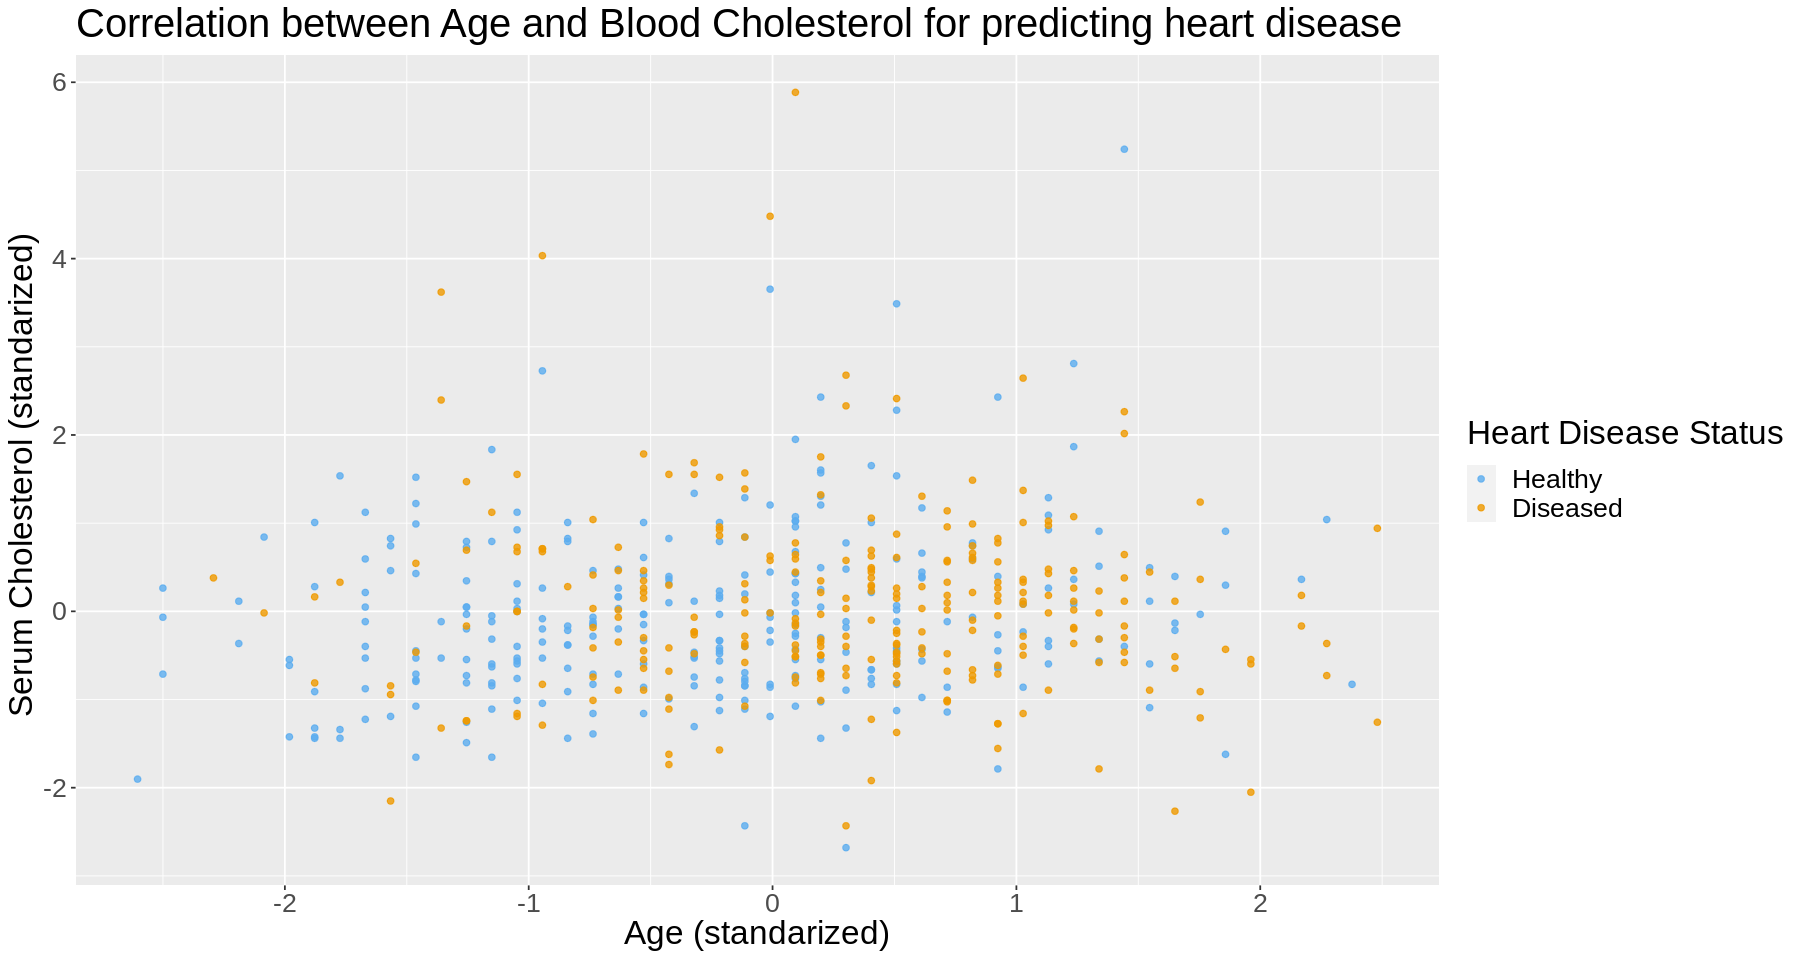

In [36]:
options(repr.plot.width = 15, repr.plot.height = 8) 

#scaterplot resting blood pressure and age 
agevsbp <- ggplot(scaled_heart, aes(x = Age, y = Cholesterol, color = HeartDisease)) +
      geom_point( alpha = 0.8) +
      xlab("Age (standarized)") +
      ylab("Serum Cholesterol (standarized) ") +
        labs(color= "Heart Disease Status")+
      theme(text = element_text(size = 20),
        legend.position = "right",
        legend.direction = "vertical") +
        scale_color_manual(labels = c("Healthy","Diseased"),
                           values= c("steelblue2","orange2"))+
        ggtitle("Correlation between Age and Blood Cholesterol for predicting heart disease") 
 agevsbp     

Figure 1: Scatter plot of Serum Cholesterol versus Age colored by heart disease status label

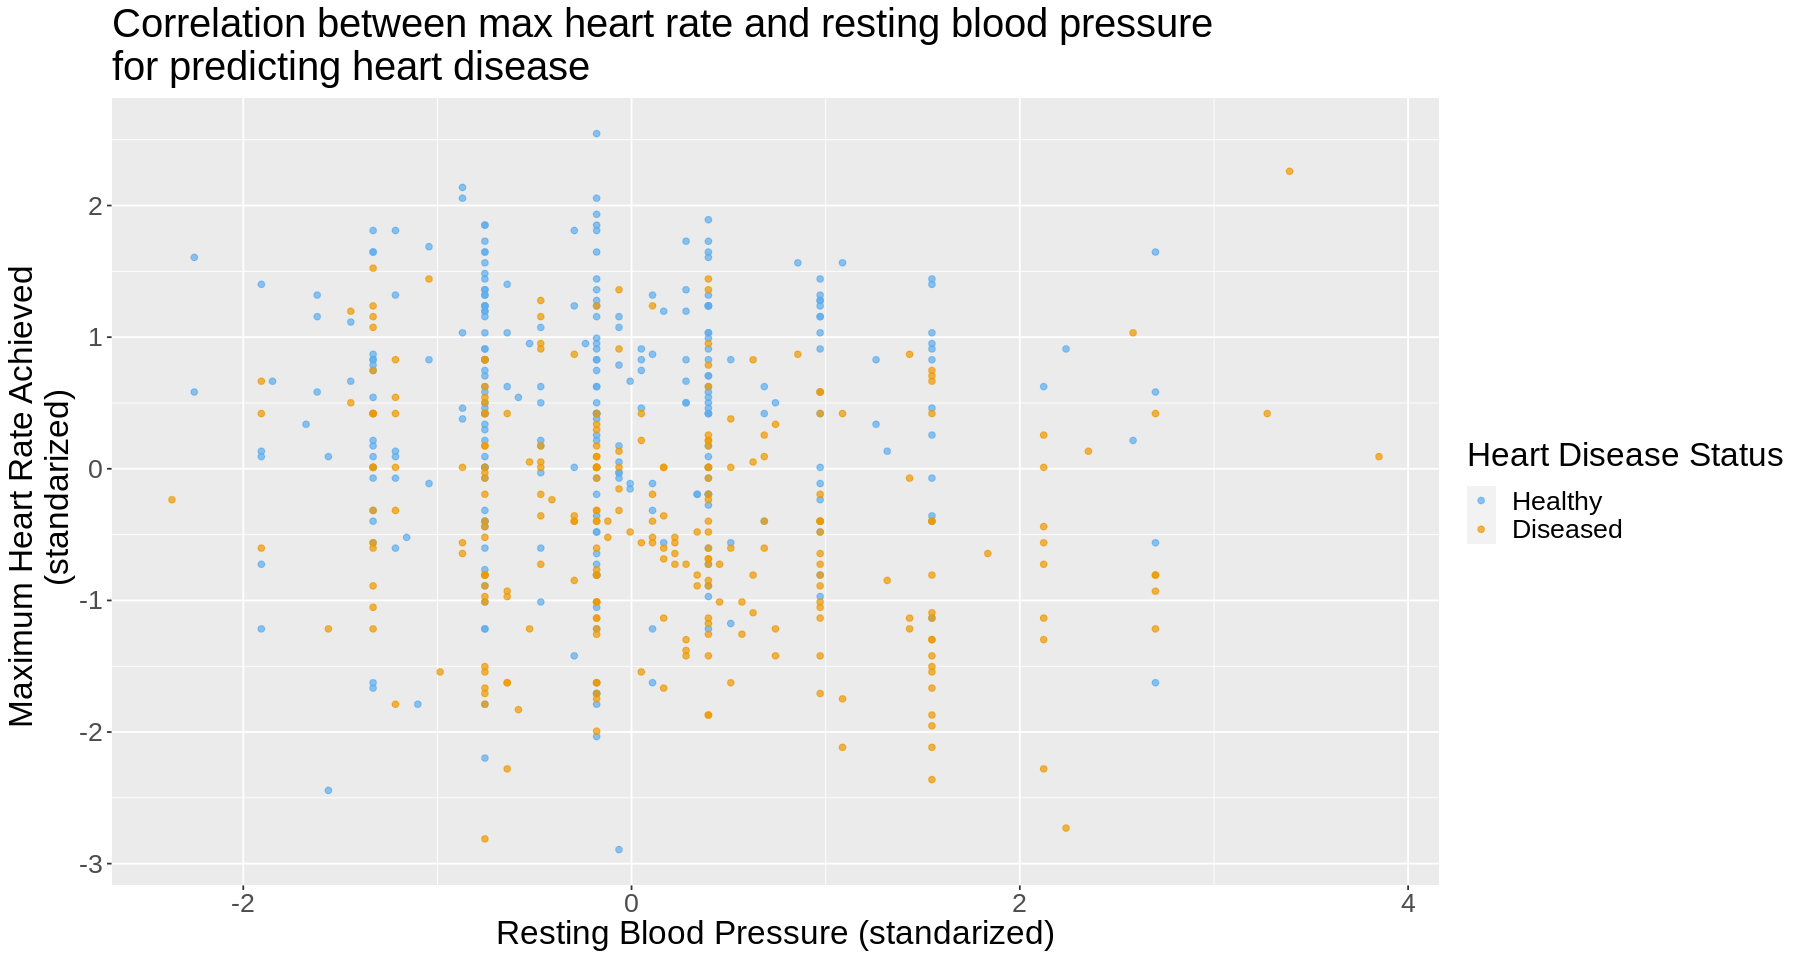

In [37]:
options(repr.plot.width = 15, repr.plot.height = 8) 
cholvshr <- ggplot(scaled_heart, aes(x = RestingBP, y = MaxHR, color = HeartDisease)) +
      geom_point(alpha = 0.7) +
      xlab("Resting Blood Pressure (standarized)") +
      ylab("Maximum Heart Rate Achieved \n (standarized)") +
      labs(color= "Heart Disease Status")+
      theme(text = element_text(size = 20),
        legend.position = "right",
        legend.direction = "vertical") +
        scale_color_manual(labels = c("Healthy","Diseased"),
                           values= c("steelblue2","orange2"))+
        ggtitle("Correlation between max heart rate and resting blood pressure \nfor predicting heart disease")
cholvshr

Figure 2: Scatter plot of maximum heart rate achieved versus resing blood pressure  colored by heart disease status label

In [38]:
describe the data add ggtitle()
describe the correlations and what it suggests about our model

ERROR: Error in parse(text = x, srcfile = src): <text>:1:10: unexpected symbol
1: describe the
             ^


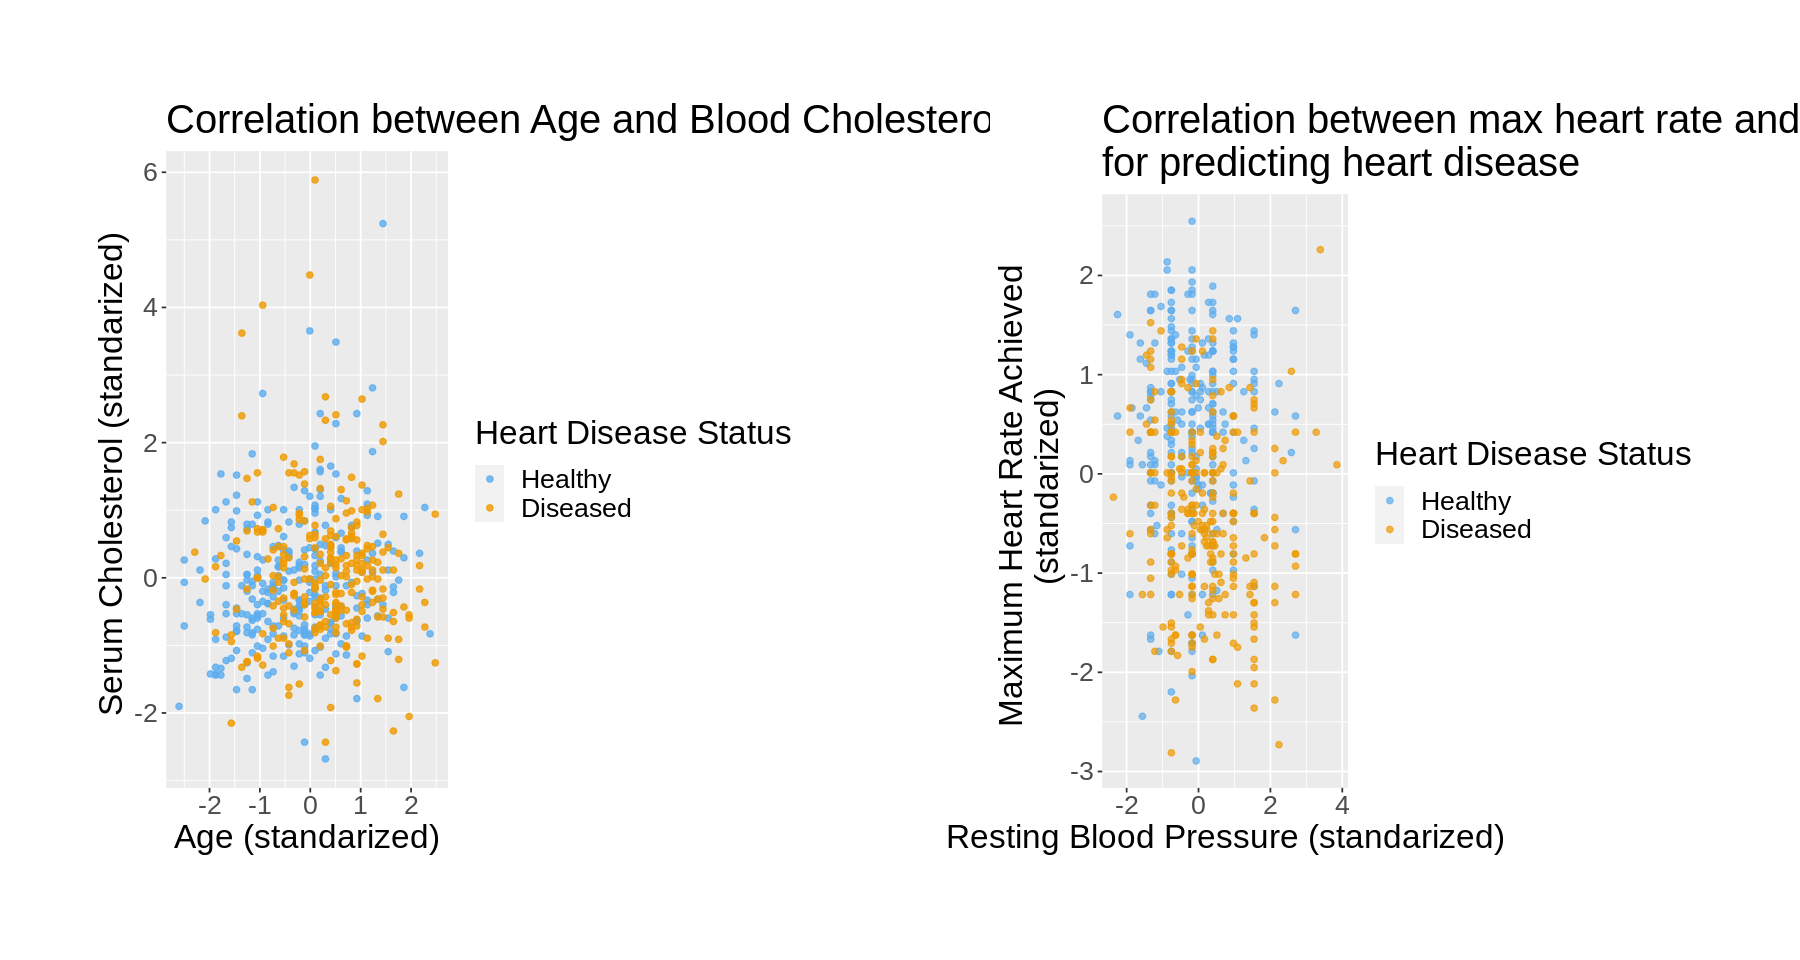

In [42]:
library (cowplot)
plot_grid(agevsbp, cholvshr, scale=0.8)

In [40]:
I think delete this we do not need it because 
we  are not comparing these two together
what do you think ???

ERROR: Error in parse(text = x, srcfile = src): <text>:1:3: unexpected symbol
1: I think
      ^


# ggtitle
(
label
=
"k-means clustering with 3 clusters"
,
subtitle
=
""
)

## Methods:
  In this project, we are using the “Heart Failure Prediction Dataset” and classification method to predict whether a person with atypical angina (ATA) chest pain has a heart disease or not. The knn classification method will be used because we want to predict heart disease status, which is a (binary) categorical variable, 1= “yes” or 0 = “no”. We will use the numerical variables (predictors) in the dataset including; age (years), resting blood pressure (mmHg), maximum heart rate, and serum cholesterol level (mm/dl) for our prediction as these numerical variables are either the risk factors or symptoms for heart disease. 

We can plot the accuracy versus number of neighbors (k-value) to find the k value with the highest accuracy using a line graph. We can also generate a scatter plot with the scaled and centered age and resting blood pressure on the axis while differentiating the heart disease status with different colors. 

## Expected outcomes and significance:

By developing this model, we expect to be able to predict heart disease accurately based on the biological determinants observed in individuals. This model is particularly significant as it filters for the individuals with ATA chest pain. Chest pain with an atypical angina is not easily diagnosed or classified as a common or obvious condition. Therefore, our model can lay the groundwork for development of models that predict or diagnose heart disease in the patients with atypical pains. Also, in our analysis, some relationships may be observed between heart disease and the predictors. These observations can lead the researchers to answer further questions like what the physiological mechanisms behind these relationships are. Another significant question that will expand this work would be how we can design one model capable of predicting heart disease in individuals with different types of chest pains and across different genders.

### percentage 

In [43]:
complete this title 
do we need this cell doublke check

ERROR: Error in parse(text = x, srcfile = src): <text>:1:10: unexpected symbol
1: complete this
             ^


In [48]:
n_row <- nrow(heart_data)

data_percentage <- heart_data |>
    group_by(HeartDisease)|>
    summarize(count=n(), percentage=n()/n_row*100)
data_percentage

n_row_train <- nrow(data_train)

data_train_percentage <- data_train |>
    group_by(HeartDisease)|>
    summarize(count=n(), percentage=n()/n_row_train*100)
data_train_percentage

HeartDisease,count,percentage
<fct>,<int>,<dbl>
0,390,52.27882
1,356,47.72118


HeartDisease,count,percentage
<fct>,<int>,<dbl>
0,292,52.23614
1,267,47.76386


### preprocess data to standardize it

In [49]:
set.seed(123)

data_vfold <- vfold_cv(heart_train, v = 10, strata = HeartDisease)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
        set_engine("kknn") |>
        set_mode("classification")

k_vals <- tibble(neighbors= seq(from= 1, to= 100, by= 5))

knn_result <- workflow()|>
    add_recipe(data_train_recipe)|>
    add_model(knn_spec)|>
    tune_grid(resamples=data_vfold, grid=k_vals)|>
    collect_metrics()

accuracies <- knn_result |>
  filter(.metric == "accuracy")

print(accuracies)

# A tibble: 20 × 7
   neighbors .metric  .estimator  mean     n std_err .config              
       <dbl> <chr>    <chr>      <dbl> <int>   <dbl> <chr>                
 1         1 accuracy binary     0.642    10  0.0109 Preprocessor1_Model01
 2         6 accuracy binary     0.669    10  0.0200 Preprocessor1_Model02
 3        11 accuracy binary     0.683    10  0.0168 Preprocessor1_Model03
 4        16 accuracy binary     0.671    10  0.0161 Preprocessor1_Model04
 5        21 accuracy binary     0.689    10  0.0195 Preprocessor1_Model05
 6        26 accuracy binary     0.694    10  0.0207 Preprocessor1_Model06
 7        31 accuracy binary     0.699    10  0.0198 Preprocessor1_Model07
 8        36 accuracy binary     0.698    10  0.0234 Preprocessor1_Model08
 9        41 accuracy binary     0.696    10  0.0240 Preprocessor1_Model09
10        46 accuracy binary     0.701    10  0.0181 Preprocessor1_Model10
11        51 accuracy binary     0.699    10  0.0211 Preprocessor1_Model11
12    

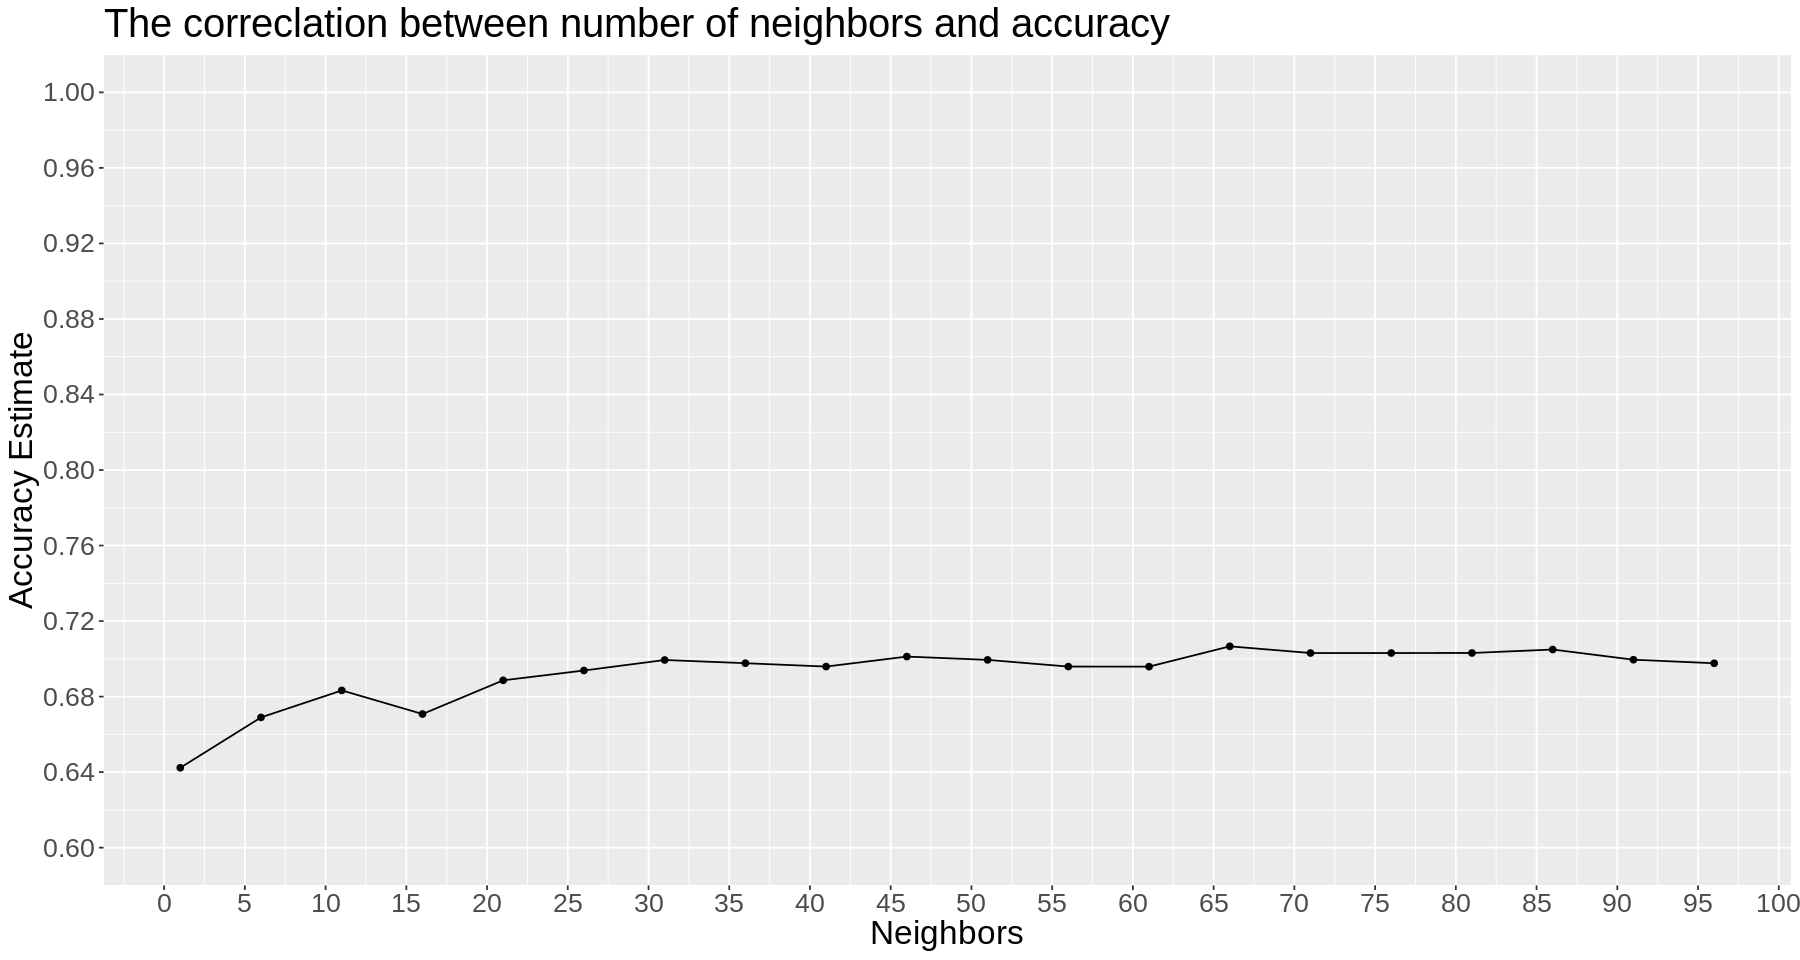

In [50]:
accuracy_vs_k <- ggplot(accuracies, aes(x=neighbors, y=mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 20))+
    scale_x_continuous(breaks = seq(0, 100, by = 5))+  
    scale_y_continuous(limits = c(0.6, 1.0), breaks=seq(0.6, 1, by=0.04))+
    ggtitle ("The correclation between number of neighbors and accuracy")
accuracy_vs_k

Figure 3: Plot of estimated accuracy versus the number of neighbors

Setting the number of neighbors to K = 66 gives the highest accuracy (70.66%). However, almost all of the k value provide almost same accuracy. Therefore,any selection from  k= 20 to k= 95  because the accuracy values on this plot are estimates of the true accuracy of the classifier. 


In [51]:
talk about wether this is good

ERROR: Error in parse(text = x, srcfile = src): <text>:1:6: unexpected symbol
1: talk about
         ^


In [52]:
maxmax<- accuracies|>
    filter(mean == max(mean))
maxmax

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
66,accuracy,binary,0.7066137,10,0.02241075,Preprocessor1_Model14


For prediction of heart disease the accuracy of the 70.66% is not a very good value for this data. Heart disease is very seriouse disease and cause a lot of death yearly so the accuracy for prediction of this data should be high. Therefore, this result suggest that prediction with these variable is not sufficient; however, it is also important to check the confusion matrix. 

In [ ]:
do we need a seed here ????
do we need to talk about majority classifier

In [53]:
#set.seed(123)

mnist_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 31) |>
       set_engine("kknn") |>
       set_mode("classification")

mnist_fit <- workflow() |>
            add_recipe(data_train_recipe) |>
            add_model(mnist_spec) |>
            fit(data = data_train)

#mnist_accurate<- mnist_fit|>
 #   collect_metrics()|>
  #          filter(.metric=="accuracy")



#mnist_accurate

In [54]:

mnist_predictions <- predict(mnist_fit, data_test)|>
        bind_cols(data_test)

mnist_predictions

mnist_metrics <- mnist_predictions |>
        metrics(truth=HeartDisease, estimate=.pred_class)

mnist_metrics

mnist_conf_mat <- mnist_predictions |>
        conf_mat(truth = HeartDisease, estimate = .pred_class)

mnist_conf_mat

.pred_class,Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,40,140,289,172,0
1,54,150,195,122,0
0,54,110,208,142,0
⋮,⋮,⋮,⋮,⋮,⋮
1,63,124,197,136,1
1,59,164,176,90,1
0,57,130,236,174,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6737968
kap,binary,0.3423465


          Truth
Prediction  0  1
         0 73 36
         1 25 53

The confusion matrix displays 73 observations were correctly predicted as healthy and 53 were correctly predicted as heart diseased. However, it shows 25 patiens as healthy when they were heart diseased and 36 patiens as diseased when they wear healthy. Therefore, the classifier determine 73 + 53 = 126 obserevation correctly, and it determines 25 + 36 = 61 obseravation mistakenly. 
As a result, this confusion matrix suggests this prediction is not very helpful as 25 heart diseased patient was mistakenly diagnosed as healthy.

explain the result 
how acccurate our model predict 
explain there might be a counfounding variable causing problem 

In [ ]:
question could be how accurate could we predit only with ata chest pain

## Refrences
1.Tsao CW, Aday AW, Almarzooq ZI, Beaton AZ, Bittencourt MS, Boehme AK, et al. Heart Disease and Stroke Statistics—2022 Update: A Report From the American Heart Association. Circulation. 2022;145(8):e153–e639.

2.Tsao CW, Aday AW, Almarzooq ZI, Beaton AZ, Bittencourt MS, Boehme AK, et al. Heart Disease and Stroke Statistics—2022 Update: A Report From the American Heart Association. Circulation. 2022;145(8):e153–e639.

3.Centers for Disease Control and Prevention, National Center for Health Statistics. About Multiple Cause of Death, 1999–2020. CDC WONDER Online Database website. Atlanta, GA: Centers for Disease Control and Prevention; 2022. Accessed February 21, 2022.

4.fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/heart-failure-prediction.
